In [ ]:
# default_exp examples

# Examples

> Examples protocol samplings

In [ ]:
from qsam.circuit import Circuit
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.samplers.protocol_samplers import Sampler, SubsetSampler
from qsam.simulators.chp import ChpSimulator

import numpy as np
import matplotlib.pyplot as plt

1. GHZ stabilizer measurement

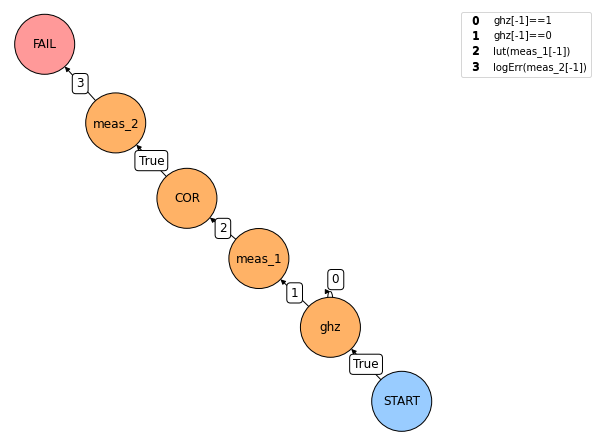

In [ ]:
ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}], ff_det=True)

# stabilizers for 4-qubit ghz state are XXXX and three ZZ parity checks
meas = Circuit([{"init": {4}},
                {"H": {4}},
                {"CNOT": {(4,0)}},
                {"CNOT": {(4,1)}},
                {"CNOT": {(4,2)}},
                {"CNOT": {(4,3)}},
                {"H": {4}},
                {"measure": {4}},
                
                {"init": {4}},
                {"CNOT": {(0,4)}},
                {"CNOT": {(1,4)}},
                {"measure": {4}},
                
                {"init": {4}},
                {"CNOT": {(1,4)}},
                {"CNOT": {(2,4)}},
                {"measure": {4}},
                
                {"init": {4}},
                {"CNOT": {(2,4)}},
                {"CNOT": {(3,4)}},
                {"measure": {4}}], noisy=False)

def logErr(m):
    return m != 0

def lut(s):
    syn = format(s, '04b')
    sx = syn[0]
    sz = syn[1:]
    #print(sx, sz)
    
    c = Circuit(noisy=False)
    
    if sx == '1':
        c.insert(tick_index=0, tick={'Z': {0}})
    
    if sz in ['001', '100', '110', '011']: #, '101']: # '111' and '010' can only guess, '000' trivial
        corrs = {'001': {3}, '100': {0}, '110': {1}, '011': {2}} #, '101': {0,3}}
        c.insert(tick_index=0, tick={'X': corrs[sz]})
    
    #print(c, c._noisy)
    return c

functions = {'logErr': logErr, 'lut': lut}

g = Protocol()
g.add_nodes_from(['ghz', 'meas_1', 'meas_2'], circuits=[ghz, meas, meas])
# können wir diese zeile irgendwie loswerden?
g.add_node('COR', circuit=Circuit(noisy=False))

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='ghz[-1]==1')
g.add_edge('ghz', 'meas_1', check='ghz[-1]==0')

g.add_edge('meas_1', 'COR', check='lut(meas_1[-1])')
g.add_edge('COR', 'meas_2', check='True')

g.add_edge('meas_2', 'FAIL', check='logErr(meas_2[-1])')

draw_protocol(g, figsize=(6,6), edge_legend=True)

In [ ]:
#slow

sample_range = np.logspace(-1,1,3)
err_params = {'p1': 0.001, 'p2': 0.01}

sam2 = Sampler(g, ChpSimulator)
p_L, std = sam2.run(n_samples=10000, sample_range=sample_range, err_params=err_params, eval_fns=functions)

Total:   0%|          | 0/3 [00:00<?, ?it/s]

p_phy=1.00E-04,1.00E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.00E-03,1.00E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=1.00E-02,1.00E-01:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
#slow

sample_range = np.logspace(-1,1,3)
err_params = {'p1': 0.001, 'p2': 0.01}

sam = SubsetSampler(g, ChpSimulator)
p_L_low, p_L_up, ss_std = sam.run(1000, sample_range, err_params, ERV_sel=True, RSE_target=0.1, chi_min=1e-2, p_max=0.08, eval_fns=functions)
print(sam)

Total:   0%|          | 0/1000 [00:00<?, ?it/s]

ghz (1000)
├── (0, 0) (2)
│   └── meas_1 (2/2, 1.08e-01)
│       └── (0,) (2)
│           └── NO FAIL (2/2, 1.08e-01)
├── (0, 1) (695)
│   ├── meas_1 (343/695, 1.37e-03)
│   │   └── (0,) (343)
│   │       ├── NO FAIL (75/343, 1.90e-03)
│   │       └── COR (268/343, 1.90e-03)
│   │           └── (0,) (268)
│   │               └── meas_2 (268/268, 4.99e-05)
│   │                   └── (0,) (268)
│   │                       └── NO FAIL (268/268, 4.99e-05)
│   └── ghz (352/695, 1.37e-03)
│       ├── (0, 0) (2)
│       │   └── meas_1 (2/2, 1.08e-01)
│       │       └── (0,) (2)
│       │           └── NO FAIL (2/2, 1.08e-01)
│       ├── (0, 1) (261)
│       │   ├── ghz (136/261, 3.62e-03)
│       │   │   ├── (0, 0) (2)
│       │   │   │   └── meas_1 (2/2, 1.08e-01)
│       │   │   │       └── (0,) (2)
│       │   │   │           └── NO FAIL (2/2, 1.08e-01)
│       │   │   └── (0, 1) (134)
│       │   │       ├── meas_1 (68/134, 6.97e-03)
│       │   │       │   └── (0,) (68)
│       │   │  

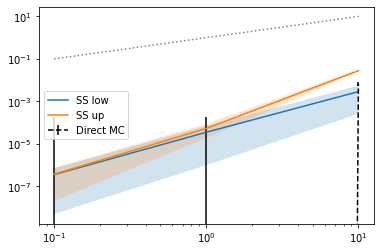

In [ ]:
#slow
#hide_input

p = sample_range
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

2. Deterministic fault-tolerant preparation of Steane code logical 0-state.

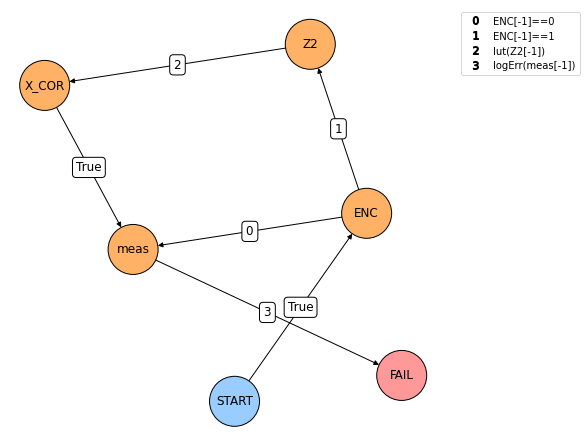

In [ ]:
eft = Circuit([ {"init": {0,1,2,4,3,5,6,7}},
                {"H": {0,1,3}},
                {"CNOT": {(0,4)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(3,5)}},
                {"CNOT": {(0,6)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(1,5)}},
                {"CNOT": {(0,2)}},
                {"CNOT": {(5,6)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(2,7)}},
                {"CNOT": {(5,7)}},
                {"measure": {7}} ])

sz_123 = Circuit([{"init": {8}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(1,8)}},
                {"CNOT": {(3,8)}},
                {"CNOT": {(6,8)}},
                {"measure": {8}}])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')
        
def flagged_z_look_up_table_1(z):
    s = [z]
    
    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

init = Protocol()
init.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas])
init.add_node('X_COR', circuit=Circuit([{'X': {6}}]))

init.add_edge('START', 'ENC', check='True')

init.add_edge('ENC', 'meas', check='ENC[-1]==0')

init.add_edge('ENC', 'Z2', check='ENC[-1]==1')
init.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')

init.add_edge('X_COR', 'meas', check='True')

init.add_edge('meas', 'FAIL', check='logErr(meas[-1])')
draw_protocol(init, figsize=(6,6), edge_legend=True)

In [ ]:
#slow

sample_range = np.logspace(-3,0,10)
err_params = {'p1': 0.0045, 'p2': 0.025}

sam = Sampler(init, ChpSimulator)
p_L, std = sam.run(n_samples=10000, sample_range=sample_range, err_params=err_params, eval_fns=functions)

sam2 = SubsetSampler(init, ChpSimulator)
p_L_low, p_L_up, ss_std = sam2.run(1000, sample_range, err_params, RSE_target=0.8, chi_min=1e-2, p_max=0.08, eval_fns=functions)
# print(sam2)

Total:   0%|          | 0/10 [00:00<?, ?it/s]

p_phy=4.50E-06,2.50E-05:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=9.69E-06,5.39E-05:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=2.09E-05,1.16E-04:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-05,2.50E-04:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=9.69E-05,5.39E-04:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=2.09E-04,1.16E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-04,2.50E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=9.69E-04,5.39E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=2.09E-03,1.16E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-03,2.50E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

Total:   0%|          | 0/1000 [00:00<?, ?it/s]

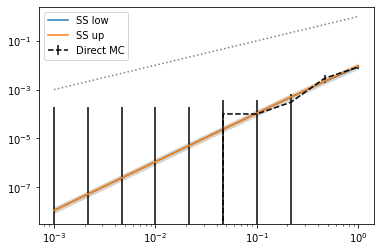

In [ ]:
#slow
#hide_input

p = sample_range
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

3. Fault-tolerant Steane flag protocol

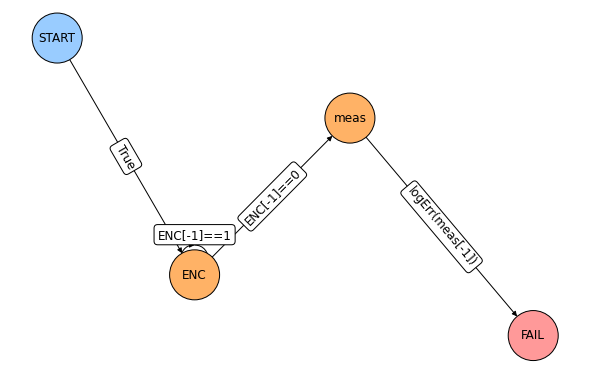

In [ ]:
eft = Circuit([ {"init": {0,1,2,3,4,5,6,7}},
                {"H": {0}},
                {"H": {1}},
                {"H": {3}},
                {"CNOT": {(0,4)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(3,5)}},
                {"CNOT": {(0,6)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(1,5)}},
                {"CNOT": {(0,2)}},
                {"CNOT": {(5,6)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(2,7)}},
                {"CNOT": {(5,7)}},
                {"measure": {7}} ])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

def logErr(out):
    
    if min([hamming2(out, i) for i in stabilizerSet]) > 1:
        return True
    else:
        return False

functions = {"logErr": logErr}

# Define protocol

init = Protocol()
init.add_nodes_from(['ENC', 'meas'], circuits=[eft, meas])

init.add_edge('START', 'ENC', check='True')

init.add_edge('ENC', 'ENC', check='ENC[-1]==1')
init.add_edge('ENC', 'meas', check='ENC[-1]==0')

init.add_edge('meas', 'FAIL', check='logErr(meas[-1])')
draw_protocol(init, figsize=(8,5), self_loop_offset=(0,0.2))

In [ ]:
#slow

sample_range = np.logspace(-3,1,5)
err_params = {'p1': 0.0045, 'p2': 0.025}

sam = Sampler(init, ChpSimulator)
p_L, std = sam.run(n_samples=10000, sample_range=sample_range, err_params=err_params, eval_fns=functions)

sam2 = SubsetSampler(init, ChpSimulator)
p_L_low, p_L_up, ss_std = sam2.run(1000, sample_range, err_params, RSE_target=0.8, chi_min=1e-2, p_max=0.08, eval_fns=functions)
# print(sam2)

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=4.50E-06,2.50E-05:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-05,2.50E-04:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-04,2.50E-03:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-03,2.50E-02:   0%|          | 0/10000 [00:00<?, ?it/s]

p_phy=4.50E-02,2.50E-01:   0%|          | 0/10000 [00:00<?, ?it/s]

RSE target of 0.1 reached.


Total:   0%|          | 0/1000 [00:00<?, ?it/s]

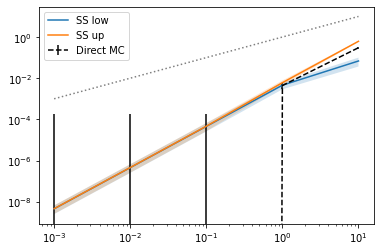

In [ ]:
#slow
#hide_input

p = sample_range
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

With the already sampled subsets we can also vary the plotted range in retrospect.

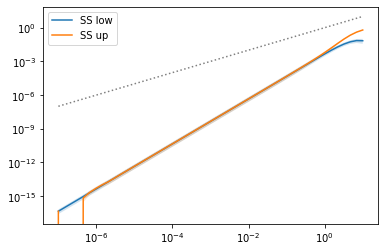

In [ ]:
#slow

p = np.logspace(-7,1,50)
err_ps = {'p1': 0.0045, 'p2': 0.025}
p_L_low = sam2.rate(p, err_ps)
var = sam2.var(p, err_ps)
ss_std = np.sqrt(var)
delta = sam2.delta(p, err_ps)
p_L_up = p_L_low + delta

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

4. Flag stabilizer protocol

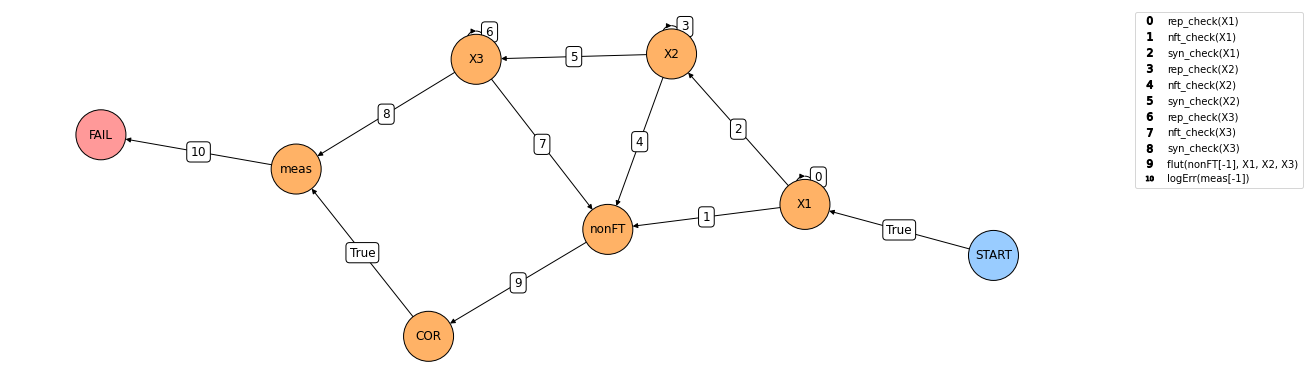

In [ ]:
fmx_1 = Circuit([{"init": {8}},
                 {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,3)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,5)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"measure": {9}} ])

fmx_2 = Circuit([{"init": {8}},
                  {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,0)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"measure": {9}} ])

fmx_3 = Circuit([{"init": {8}},
              {"H": {8}},
                {"init": {9}},
                {"CNOT": {(8,1)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,5)}},
                {"CNOT": {(8,9)}},
                {"CNOT": {(8,6)}},
                 {"H": {8}},
                {"measure": {8}},
                {"measure": {9}} ])

nfs = Circuit([{"init": {7,8,9}},
               {"H": {7,8,9}},
                {"CNOT": {(7,3)}},
                {"CNOT": {(7,4)}},
                {"CNOT": {(7,5)}},
                {"CNOT": {(7,6)}},
                {"CNOT": {(8,0)}},
                {"CNOT": {(8,2)}},
                {"CNOT": {(8,4)}},
                {"CNOT": {(8,6)}},
                {"CNOT": {(9,1)}},
                {"CNOT": {(9,2)}},
                {"CNOT": {(9,5)}},
                {"CNOT": {(9,6)}},
                {"H": {7,8,9}},
                {"measure": {7,8,9}},
                {"init": {7,8,9}},
                {"CNOT": {(3,7)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(5,7)}},
                {"CNOT": {(6,7)}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(2,8)}},
                {"CNOT": {(4,8)}},
                {"CNOT": {(6,8)}},
                {"CNOT": {(1,9)}},
                {"CNOT": {(2,9)}},
                {"CNOT": {(5,9)}},
                {"CNOT": {(6,9)}},
                {"measure": {7,8,9}} ])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count

def logErr(out):
    if min([hamming2(out, i) for i in stabilizerSet]) > 1:
        return True
    else:
        return False

def flagged(m):
    v = 0b01 in m or 0b11 in m if m is not None else False
    #print('flag', [format(i, '02b') for i in m], ':', v)
    return v

def flut(m, f1, f2, f3):
    formatter = lambda i,m: str(format(m, '06b')[i])
    
    sx = ''.join([formatter(i,m) for i in range(3)])
    sz = ''.join([formatter(i,m) for i in range(3,6)])
    
    if (sz == '011' and flagged(f1)) or (sz == '011' and flagged(f2)) or (sz == '011' and flagged(f3)):
        
        corrs = {'011': {4, 5}, '101': {2, 4}, '110': {2, 5}} #{'010': {5, 6}, '001': {4, 6}}
        return Circuit([{'X': corrs[sz]}], noisy=False)
    
    else:
            
        return Circuit(noisy=False)

def rep_check(m):
    # no flag triggered, run second round regardless of syndrome
    v = (m[-1] == 0b00 or m[-1] == 0b10) and len(m) == 1
    #print('rep', [format(i, '02b') for i in m], ':', v)
    return v

def nft_check(m):
    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    v = (len(m) == 1 and (m[-1] == 0b01 or m[-1] == 0b11)) or (len(m) == 2 and ((m[-1] == 0b00 and m[-2] == 0b10) or (m[-1] == 0b10 and m[-2] == 0b00) or (m[-1] == 0b01 or m[-1] == 0b11)))
    #print('nft', [format(i, '02b') for i in m], ':', v)
    return v

def syn_check(m):
    # no flag triggered, syndromes agree in second round
    v = len(m) == 2 and ((m[-1] == 0b00 and m[-2] == 0b00) or (m[-1] == 0b10 and m[-2] == 0b10))
    #print('syn', [format(i, '02b') for i in m], ':', v)
    return v

functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check": nft_check, "syn_check": syn_check}

# Define protocol

init = Protocol()
init.add_nodes_from(['X1', 'X2', 'X3', 'nonFT', 'meas'], circuits=[fmx_1, fmx_2, fmx_3, nfs, meas])
init.add_node('COR', circuit=Circuit(noisy=False))

init.add_edge('START', 'X1', check='True')

# no flag triggered, run second round regardless of syndrome
init.add_edge('X1', 'X1', check='rep_check(X1)')
init.add_edge('X2', 'X2', check='rep_check(X2)')
init.add_edge('X3', 'X3', check='rep_check(X3)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
init.add_edge('X1', 'nonFT', check='nft_check(X1)')
init.add_edge('X2', 'nonFT', check='nft_check(X2)')
init.add_edge('X3', 'nonFT', check='nft_check(X3)')

# no flag triggered, syndromes agree in second round
init.add_edge('X1', 'X2', check='syn_check(X1)')#False if rep_check(X1) or nft_check(X1) else True')
init.add_edge('X2', 'X3', check='syn_check(X2)')#'False if rep_check(X2) or nft_check(X2) else True')
init.add_edge('X3', 'meas', check='syn_check(X3)')#'False if rep_check(X3) or nft_check(X3) else True')

# apply flag correction after nonFT if a flag was triggered
init.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1, X2, X3)')

init.add_edge('COR', 'meas', check='True')

init.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

draw_protocol(init, edge_legend=True, figsize=(15,5))

In [ ]:
#slow

sample_range = np.logspace(-3,1,3)
err_params = {'p1': 0.001, 'p2': 0.01}
 
sam = Sampler(init, ChpSimulator)
p_L, std = sam.run(n_samples=1000000, sample_range=sample_range, err_params=err_params, eval_fns=functions)

Total:   0%|          | 0/3 [00:00<?, ?it/s]

p_phy=1.00E-06,1.00E-05:   0%|          | 0/1000000 [00:00<?, ?it/s]

p_phy=1.00E-04,1.00E-03:   0%|          | 0/1000000 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


p_phy=1.00E-02,1.00E-01:   0%|          | 0/1000000 [00:00<?, ?it/s]

RSE target of 0.1 reached.


In [ ]:
#slow

sample_range = np.logspace(-3,1,3)
err_params = {'p1': 0.001, 'p2': 0.01}

sam2 = SubsetSampler(init, ChpSimulator)
p_L_low, p_L_up, ss_std = sam2.run(10000, sample_range, err_params, ERV_sel=True, RSE_target=0.8, chi_min=1e-8, p_max=0.01, eval_fns=functions)
# print(sam2)

Total:   0%|          | 0/10000 [00:00<?, ?it/s]

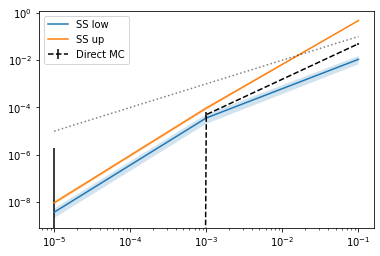

In [ ]:
#slow
#hide_input

p = sample_range * err_params['p2']
plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)

plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();